In [528]:
import numpy as np
import pims
from lib import detection
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import stats
from scipy import signal
from skimage import feature
import math

import rpy2
from rpy2.robjects import numpy2ri
numpy2ri.activate()

import seaborn as sns
import pandas as pd

In [38]:
def report_performance(events, puff_idsmovie_subsets):
    num_puffs = np.shape(np.array(markers))[0]
    detected_puffs = np.sum(puff_ids>0)
    unique_puffs = len(np.unique(puff_ids[puff_ids>0]))
    num_events = len(np.unique(events['particle']))
    puff_freq = unique_puffs/num_events
    print('%d/%d puffs (%d unique) in %d events (%.5f freq)' % 
          (detected_puffs, num_puffs, unique_puffs, num_events, puff_freq))

def gauss_laplace_fa(frame, sigma):
    window = math.ceil(4*sigma)
    fg = ndimage.gaussian_filter(frame, sigma)
    extended_frame = np.pad(frame, window, mode='reflect')

    x = np.arange(-window, window+1)
    gauss_1d = np.exp(-np.power(x,2)/(2.*sigma**2.))
    gx2 = gauss_1d*x**2
    
    imgLoG = (2*fg/sigma**2 - 
              (signal.convolve2d(gauss_1d*gx2.reshape(-1,1), extended_frame, 'valid') +
               signal.convolve2d(gx2*gauss_1d.reshape(-1,1), extended_frame, 'valid'))/sigma**4)
    imgLoG = imgLoG / (2*math.pi*sigma**2)
    return imgLoG

def gauss_laplace_scipy(frame, sigma):
    fg = ndimage.gaussian_filter(frame, sigma)
    imgLoG = ndimage.gaussian_laplace(fg, sigma)
    return imgLoG

In [30]:
movie = pims.TiffStack('data/videos/OPP/0IYVHRNA.tif')
markers = detection.import_xml_data('data/videos/OPP/0IYVHRNA-ZYW-1.xml')
markers_subset = [marker for marker in markers if marker[2] in range(1975,2275)]
markers_subset = [[marker[0], marker[1], marker[2]-1975] for marker in markers_subset]
movie_subset = movie[1974:2274]

mask = detection.get_mask(movie_subset)
masked_subset = movie_subset * mask

sigma = 1.26
frame = masked_subset[0]

In [606]:
averaged_subset = ndimage.uniform_filter(movie_subset[:], size=(5,0,0))

In [607]:
locs = detection.find_locs(averaged_subset)

/Volumes/Coatamer/Users/weinberz/Google Drive/Code/puffapy/lib/detection.py:215: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  (linear_blurred < percentiles[1])])


In [608]:
events = tp.link_df(locs, search_range=1.5, memory=0)

In [615]:
events = tp.filter_stubs(events, 4)
puff_ids = np.array([detection.filter_df(events, m, 5) for m in markers_subset])
events['puff'] = events['particle'].isin(puff_ids).astype(int)

In [619]:
intensities = detection.intensity_grid(movie_subset,events[['frame','x','y','particle']])

In [623]:
events.to_csv('test.csv',index=False)

In [ ]:
movie = pims.TiffStack('/Volumes/Coatamer/Users/weinberz/UM Drive/OPP/79NWKD4H.tif')
markers = detection.import_xml_data('/Volumes/Coatamer/Users/weinberz/UM Drive/OPP/79NWKD4H-ZYW-1.xml')
averaged_movie = ndimage.uniform_filter(movie[:], size=(5,0,0))
locs = detection.find_locs(averaged_movie)

In [590]:
from skimage.restoration import denoise_wavelet

mask = detection.get_mask(averaged_movie)
filter_points = True
for idx, frame in enumerate(averaged_movie):
    background_frame, signif_mask = detection.get_loc_background(frame)
    frame = denoise_wavelet(frame, multichannel=False)
    gls = [-ndimage.filters.gaussian_laplace(frame, sig) * sig **2 for sig in sigma_list]
    
    if mask is None:
        mask = np.ones(np.shape(frame))
    if filter_points:
        mask = mask * signif_mask
        
    plm = [feature.peak_local_max(x, indices=False) for x in gls]
    plm = [np.transpose(np.nonzero(x & mask))[::-1] for x in plm]
    plmval = np.concatenate([[gls[i][r, c] for (r, c) in plm[i]] for i in range(len(sigma_list))])
    sigmas_of_peaks = np.concatenate([np.repeat(sigma_list[i], len(plm[i])) for i in range(len(sigma_list))])
    plm = np.hstack([np.concatenate(plm), sigmas_of_peaks.reshape(len(sigmas_of_peaks), 1)])

    loc_background = np.array([background_frame[int(loc_max[0]), int(loc_max[1])] for loc_max in plm])
    try:
        coef = detection.gev_glm(plmval, sigmas_of_peaks, loc_background)
    except rpy2.rinterface.RRuntimeError:
        print(idx)

71
78
79
80
98
101
146
147
149
152
160
163
164
165
166
167
172
180
183
184
196
198
208
209
212
213
214
215
216
217
219
223
224
225
231
232
233
234
235
236
237
238
239
246
249
250
251
252
253
256
257
261
265
266
267
268
269
270
271
272
273
274
275
276
279
280
281
282
288
289
291
294
297
302
303
304
310
311
312
313
314
316
318
320
322
323
327
333
334
335
336
337
338
339
347
348
349
350
351
354
356
357
358
359
360
367
368
369
370
371
372
373
374
375
378
379
380
386


KeyboardInterrupt: 

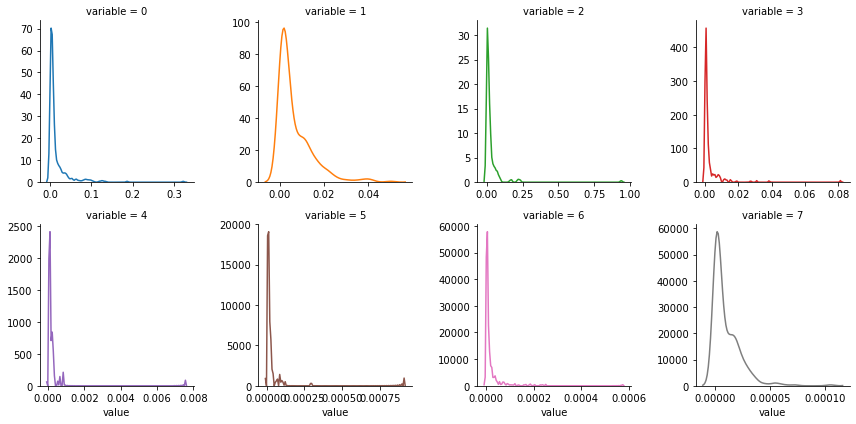

In [533]:
coefs_df = pd.DataFrame(np.vstack([x.flatten() if isinstance(x,np.ndarray) else numpy2ri.ri2py(x).flatten() for x in coefs])).melt()
coefs_df = coefs_df[coefs_df['value']>0]
sns.FacetGrid(coefs_df, col = 'variable', hue = 'variable', sharex=False, sharey=False, col_wrap=4).map(sns.kdeplot,'value')

In [536]:
coefs_df.groupby('variable').mean()

,value
variable,
0,0.015278
1,0.006694
2,0.027649
3,0.002742
4,0.000116
5,0.000016
6,0.000018
7,0.000010


In [598]:
mask = detection.get_mask(averaged_movie)
frame = averaged_movie[2800]
background_frame, signif_mask = detection.get_loc_background(frame)
frame = denoise_wavelet(frame, multichannel=False)
gls = [-ndimage.filters.gaussian_laplace(frame, sig) * sig **2 for sig in sigma_list]

if mask is None:
    mask = np.ones(np.shape(frame))
if filter_points:
    mask = mask * signif_mask

plm = [feature.peak_local_max(x, indices=False) for x in gls]
plm = [np.transpose(np.nonzero(x & mask))[::-1] for x in plm]
plmval = np.concatenate([[gls[i][r, c] for (r, c) in plm[i]] for i in range(len(sigma_list))])
sigmas_of_peaks = np.concatenate([np.repeat(sigma_list[i], len(plm[i])) for i in range(len(sigma_list))])
plm = np.hstack([np.concatenate(plm), sigmas_of_peaks.reshape(len(sigmas_of_peaks), 1)])

loc_background = np.array([background_frame[int(loc_max[0]), int(loc_max[1])] for loc_max in plm])
coef = detection.gev_glm(plmval, sigmas_of_peaks, loc_background)

In [600]:
coef

-0.000932,0.000073,0.000004,-0.000000,-0.000497,0.000067,0.000002,-0.000000


In [79]:
def gauss_laplace_fa(frame, sigma):
    window = math.ceil(4*sigma)
    fg = ndimage.gaussian_filter(frame, sigma)
    extended_frame = np.pad(frame, window, mode='reflect')

    x = np.arange(-window, window+1)
    gauss_1d = np.exp(-np.power(x,2)/(2.*sigma**2.))
    gx2 = gauss_1d*x**2
    
    imgLoG = (2*fg/sigma**2 - 
              (signal.convolve2d(gauss_1d*gx2.reshape(-1,1), extended_frame, 'valid') +
               signal.convolve2d(gx2*gauss_1d.reshape(-1,1), extended_frame, 'valid'))/sigma**4)
    imgLoG = imgLoG / (2*math.pi*sigma**2)
    return imgLoG

def gauss_laplace_scipy(frame, sigma):
    fg = ndimage.gaussian_filter(frame, sigma)
    imgLoG = ndimage.gaussian_laplace(fg, sigma)
    return imgLoG

(-0.5, 299.5, 299.5, -0.5)

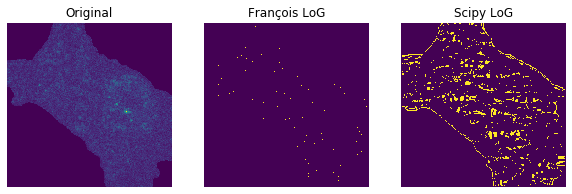

In [80]:
sigma = 3
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,15))
axs = axs.ravel()
axs[0].imshow(frame)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(feature.peak_local_max(-gauss_laplace_fa(frame,sigma), indices=False))
axs[1].set_title(u'François LoG')
axs[1].axis('off')
axs[2].imshow(feature.peak_local_max(-gauss_laplace_scipy(frame,sigma), indices=False))
axs[2].set_title('Scipy LoG')
axs[2].axis('off')

(-0.5, 299.5, 299.5, -0.5)

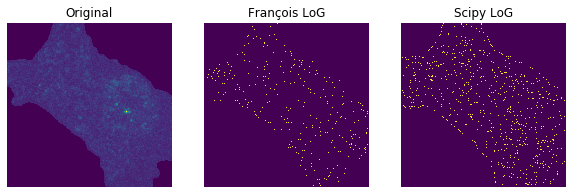

In [10]:
averaged_subset = ndimage.uniform_filter(movie_subset[:], size=(5,0,0))
masked_average = averaged_subset * mask
frame = masked_average[0]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,15))
axs = axs.ravel()
axs[0].imshow(frame)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(feature.peak_local_max(-gauss_laplace_fa(frame,sigma), indices=False))
axs[1].set_title(u'François LoG')
axs[1].axis('off')
axs[2].imshow(feature.peak_local_max(-gauss_laplace_scipy(frame,sigma), indices=False))
axs[2].set_title('Scipy LoG')
axs[2].axis('off')

In [473]:
st_time = time.time()
locs = detection.find_locs(averaged_subset, cutoff=0.9)
end_time = time.time() - st_time
events = tp.link_df(locs, search_range=1.5, memory=0)
events = tp.filter_stubs(events, 4)
puff_ids = np.array([detection.filter_df(events, m, 5) for m in markers_subset])
print(end_time)
report_performance(events, puff_ids, markers_subset)

Frame 299: 29 trajectories present.
49.80077791213989
6/6 puffs (6 unique) in 596 events (0.01007 freq)


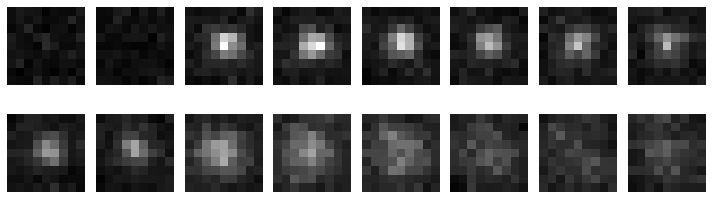

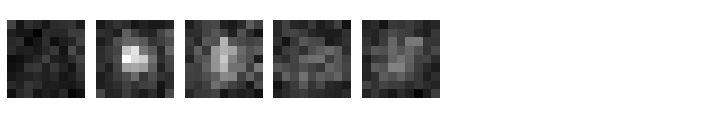

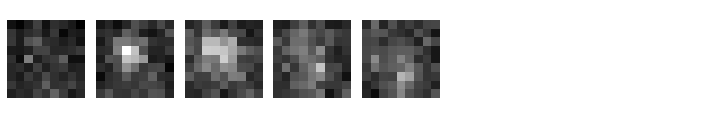

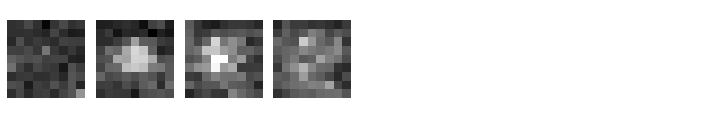

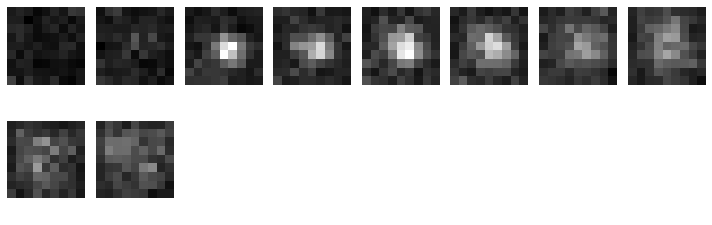

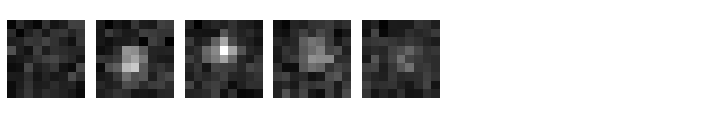

In [471]:
from lib import display
intensities = detection.intensity_grid(movie_subset, events)
for puff_id in puff_ids[puff_ids>0]:
    frames = display.get_frames(intensities.loc[intensities['particle'] == puff_id,:])
    fig, axs = display.plot_montage(frames)